# Basketball Analysis

## Mathematical Power Ranking using Chess ELO
ELO is used to correct for opponent strength (a win versus someone better than you is more meaningful than one against someone worse than you skill wise)

Basketball Power Ranking skewed because Western Conference much stronger than East (teams play other teams in their own conference 4 times and opposite conference teams 2 times) which makes Win-Loss inadequate to determine how to rank the entire NBA

### Import Libraries

In [44]:
! pip install nba_api

In [231]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

### Importing ELO file

In [232]:
#At the beginning of the season every team starts at 1000 ELO winning increases ones ELO while losing decreases
#Importing file that starts with every team having 1000 ELO and updated values as season progresses
ELO = pd.read_csv('ELO.csv')

### Previous Nights BoxScores from Basketball Reference

In [233]:
NBA_URL = 'https://www.basketball-reference.com/boxscores/'

### ELO updating function 

In [234]:
def ELO_pergame(URL):
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find(id = 'content')

    Game_sum = results.find('div', class_ = 'game_summaries')
    Game_sum = Game_sum.find_all('div', class_ = 'game_summary expanded nohover') #Finds number of games on a given day
    

    for i in range(len(Game_sum)):
        
        #Updating ELO for the team that won
        Game = Game_sum[i]
        Winner = Game.find('tr', class_= 'winner')
        Winner = Winner.find('a').text
        Winner_ind = ELO[ELO['Team']==Winner].index.tolist()
            
        #Updating ELO for the team that lost    
        Loser = Game.find('tr', class_= 'loser')
        Loser = Loser.find('a').text
        Loser_ind = ELO[ELO['Team']==Loser].index.tolist()
        
        #Calculates the Probability of each team winning based on ELO before the game
        Prob_Winner = 1/(1 + 10**((float(ELO['ELO'][Loser_ind]) - float(ELO['ELO'][Winner_ind]))/400))
        Prob_Loser = 1/(1 + 10**((float(ELO['ELO'][Winner_ind]) - float(ELO['ELO'][Loser_ind]))/400))

        #New ELO
        ELO.at[Winner_ind, 'ELO'] = float(ELO['ELO'][Winner_ind]) + 100*(1.0 - Prob_Winner)
        ELO.at[Loser_ind, 'ELO'] = float(ELO['ELO'][Loser_ind]) + 100*(0.0 - Prob_Loser)

In [235]:
ELO_pergame(NBA_URL)
ELO.to_csv('ELO.csv', index = False)

### Graphing ELO Rankings of entire NBA

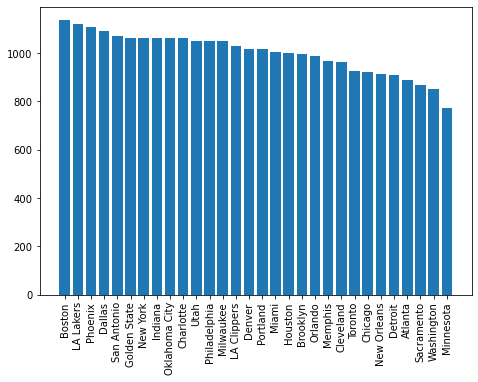

In [236]:
ELO = ELO.sort_values(by = ['ELO'], ascending = False)
ELO = ELO.reset_index()
ELO = ELO.drop(columns = ['index'])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ELO['Team'], ELO['ELO'])
plt.xticks(rotation = 90)
plt.show()

### Table view of ELO rankings

 Table of contents https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md
 
 Static tables = input parameters to send to endpoints (static is player ids and team ids)

In [237]:
#Imports for nba_api 
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguestandings
team_dict = teams.get_teams()

In [238]:
#Dictionary to convert team names from basketball reference format to nba_api format
team_conv = {
            'Philadelphia':'Philadelphia 76ers',
            'LA Lakers':'Los Angeles Lakers',
            'New York': 'New York Knicks',
            'Phoenix': 'Phoenix Suns',
            'Indiana': 'Indiana Pacers',
            'Orlando': 'Orlando Magic',
            'Boston': 'Boston Celtics',
            'LA Clippers': 'Los Angeles Clippers',
            'Milwaukee': 'Milwaukee Bucks',
            'Golden State': 'Golden State Warriors',
            'Denver': 'Denver Nuggets',
            'Oklahoma City': 'Oklahoma City Thunder',
            'Utah': 'Utah Jazz',
            'Brooklyn': 'Brooklyn Nets',
            'Dallas': 'Dallas Mavericks',
            'San Antonio': 'San Antonio Spurs',
            'Charlotte' : 'Charlotte Hornets',
            'Cleveland': 'Cleveland Cavaliers',
            'Sacramento': 'Sacramento Kings',
            'Miami': 'Miami Heat',
            'New Orleans': 'New Orleans Pelicans',
            'Chicago': 'Chicago Bulls',
            'Portland': 'Portland Trail Blazers',
            'Memphis': 'Memphis Grizzlies',
            'Houston': 'Houston Rockets',
            'Atlanta': 'Atlanta Hawks',
            'Washington': 'Washington Wizards',
            'Toronto': 'Toronto Raptors',
            'Detroit': 'Detroit Pistons',
            'Minnesota': 'Minnesota Timberwolves'
            }

In [239]:
#Generating dataframe of TeamID, WINS, LOSSES to append WINS and LOSSES to ELO
Standings = leaguestandings.LeagueStandings(season = '2020').get_data_frames()[0]
WL_df = Standings[['TeamID','WINS', 'LOSSES']]

In [242]:
#Updates ELO with nba_api TeamID, Wins, and Losses
#ELO = ELO.drop(columns = ['TeamID'])
for i in ELO['Team']:
    Name = team_conv[i]
    for team in team_dict:
        if team['full_name'] == Name:
            ind = ELO.index[ELO['Team'] == i][0]
            pd.set_option('precision', 10)
            ELO.at[ind, 'ID'] = team['id']
    
ELO = ELO.rename(columns = {'ID': 'TeamID'})
ELO['TeamID'] = ELO['TeamID'].astype(int)
ELO_table = ELO.merge(WL_df, on = 'TeamID')

In [243]:
ELO_table

,Team,ELO,TeamID,WINS,LOSSES
0,Boston,1135.1951930476,1610612738,7,3
1,LA Lakers,1117.7541020322,1610612747,7,3
2,Phoenix,1105.6362041030,1610612756,7,3
3,Dallas,1088.9970767928,1610612742,5,4
4,San Antonio,1071.3060352173,1610612759,5,4
5,Golden State,1063.8015724247,1610612744,5,4
6,New York,1063.6748832435,1610612752,5,4
7,Indiana,1062.7647300485,1610612754,6,3
8,Oklahoma City,1061.6487571107,1610612760,4,4
9,Charlotte,1060.3083830912,1610612766,5,5
